In [2]:
!pip install pandas
!pip install xlrd
!pip install 'pandas-profiling==2.8.0'
!pip install seaborn
from scipy.stats import chi2
from scipy.stats import chi2_contingency

Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'c:\program files (x86)\python38-32\python.exe -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'c:\program files (x86)\python38-32\python.exe -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeableWARNING: pip is being invoked by an old script wrapper. This will fail in a future version of pip.
Please see https://github.com/pypa/pip/issues/5599

In [3]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot

sns.set_style(style="whitegrid")

In [4]:
df_hurtos = pd.concat([
    pd.read_excel('data/hurto-de-automotores-2017_0.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2018_0.xls', skiprows=8),
    pd.read_excel('data/hurto-de-automotores-2018_1.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2019_0.xls', skiprows=8)
])

# Limpieza

In [5]:
# Correción de valores de edad y cantidad. 
# Edad -1 representa que no se conoce la edad del individuo
# Cantidad 1000 se borra en un paso posterior.
df_hurtos['Edad'] = df_hurtos['Edad'].fillna('-1')
df_hurtos['Edad'] = df_hurtos['Edad'].astype(str)
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-']
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-1']

# Corrección de tipos.
cols_str = [
    'Fecha','Hora', 'Departamento', 'Municipio', 'Día', 'Barrio', 'Zona', 'Clase de sitio', 
    'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Sexo', 'Estado civil' ,
    'País de nacimiento','Clase de empleado', 'Profesión', 'Escolaridad', 'Código DANE', 'CLASE',
    'MARCA', 'LINEA', 'MODELO', 'COLOR']
for col in cols_str:
    df_hurtos[col] = df_hurtos[col].astype(str)

df_hurtos['Edad'] = df_hurtos['Edad'].astype('int64')

# Remoción de duplicados
df_hurtos.drop_duplicates(inplace=True)

# Remoción de valores atípicos/outliers. 
# 1. Constantes
df_hurtos.drop(columns=['Cantidad', 'Profesión', 'Zona', 'Barrio', 'País de nacimiento'], inplace=True)
# 2. Registros con edad mayor a 110
df_hurtos = df_hurtos[df_hurtos['Edad'] < 110]

# Creación de nuevas columnas
df_hurtos['Fecha'] = df_hurtos['Fecha'].apply(lambda x: x[:11])
df_hurtos['Mes'] = df_hurtos['Fecha'].apply(lambda x: x[5:7])

# Categorización de la variable Hora
def hora_to_cat(hora):
    if hora == 'na':
        return "No_especificada"
    hora = int(hora)

    if hora > 0 and hora <= 4:
        return '(00-04]'
    if hora > 4 and hora <= 8:
        return '(04-08]'
    if hora > 8 and hora <= 12:
        return '(08-12]'
    if hora > 12 and hora <= 16:
        return '(12-16)'
    if hora > 16 and hora <= 20:
        return '(16-20]'
    if hora == 0 or hora > 20:
        return '(20-24]'
df_hurtos['Hora_Cat'] = df_hurtos['Hora'].apply(lambda hora: hora_to_cat(hora[:2]))


In [6]:
colores_dict = {
    'ABANO': 'BLANCO', 'BEIGE': 'BLANCO', 'BLANCO': 'BLANCO', 'BLANCO Y VERDE': 'BLANCO', 'CHAMPAÑA': 'BLANCO', 'CREMA': 'BLANCO', 'MARFIL': 'BLANCO', 'PERLA': 'BLANCO',
    'SAHARA': 'BLANCO', 

    'ACEITUNA': 'VERDE', 'BOSQUE': 'VERDE', 'JADE': 'VERDE', 'LIMON': 'VERDE', 'VERDE': 'VERDE', 'VERDE OSCURO': 'VERDE', 

    'BAMBOO': 'CAFE','CAFE': 'CAFE', 'CARAMELO': 'CAFE', 'HABANO': 'CAFE', 'MARRON': 'CAFE', 'PARDO LAGUNA': 'CAFE', 'ROBLE': 'CAFE', 'TABACO': 'CAFE', 'TERRANOVA': 'CAFE',

    'ACERO': 'GRIS', 'CENIZA GRAFITO': 'GRIS', 'CROMADO': 'GRIS', 'ESTRATO DE PERLA':'GRIS', 'GRAFITO': 'GRIS', 'GRIS': 'GRIS', 'GRIS PLATINO': 'GRIS', 'PLATA': 'GRIS',
    'PLATA NIQUEL': 'GRIS','PLATEADO': 'GRIS', 'PLATINO': 'GRIS', 'STRATO PLATA': 'GRIS', 'SILICE TORNADO': 'GRIS', 'TOLEDANO': 'GRIS',

    'ACUARELA': 'AZUL', 'AZUL': 'AZUL', 'AZUL BAHIA': 'AZUL', 'AZUL BALTICO': 'AZUL', 'AZUL CIELO': 'AZUL', 'AZUL LAGUNA': 'AZUL', 'AZUL LISBOA' : 'AZUL', 
    'AZUL MEDIO': 'AZUL', 'AZUL Y BLANCO': 'AZUL', 'AZUL ZAFIRO': 'AZUL', 'CELESTE': 'AZUL', 'CIELO': 'AZUL', 'TURQUEZA': 'AZUL', 'ZAFIRO': 'AZUL',

    'BRONCE': 'NARANJA', 'COBRE': 'NARANJA', 'FUEGO': 'NARANJA', 'LADRILLO': 'NARANJA', 'MANDARINA': 'NARANJA', 'NARANJA': 'NARANJA', 'OTOÑAL': 'NARANJA', 
    'ZAPOTE': 'NARANJA',

    'BRUMA': 'MORADO', 'FIRMAMENTO': 'MORADO', 'IMPERIAL': 'MORADO', 'LILA': 'MORADO', 'MORADO CORDOBES': 'MORADO', 'VINOTINTO': 'MORADO', 'VIOLETA': 'MORADO', 

    'CEREZA': 'ROJO', 'ROJO': 'ROJO','ROJO - BLANCO': 'ROJO','ROJO-MARRON-ROYAL': 'ROJO','ROJO-VERDE': 'ROJO', 'TERRACOTA': 'ROJO',

    'NEGRO': 'NEGRO', 'NEGRO GRAFITO': 'NEGRO', 'NEGRO Y BLANCO': 'NEGRO', 'NEGRO Y NIQUEL': 'NEGRO',  

    'CINZA EJECUTIVO': 'OTRO', 'CLASICO': 'OTRO', 'COLONIAL': 'OTRO', 'METALIZADO': 'OTRO', 'NO REPORTADO': 'OTRO', 'PRIMER': 'OTRO', 'QUARZO': 'OTRO', 
    'SAFARI': 'OTRO', 'VARIOS COLORES': 'OTRO', '-': 'OTRO',

    'AMARILLO': 'AMARILLO', 'AMARILLO TRANSITO': 'AMARILLO', 'AMARILLO Y BLANCO': 'AMARILLO', 'AMARILLO Y NEGRO': 'AMARILLO', 'DORADO': 'AMARILLO', 
    'MOSTAZA': 'AMARILLO', 'ORO': 'AMARILLO'
}

In [7]:
# Agrupación de colores
df_hurtos['COLOR'] = df_hurtos['COLOR'].apply(lambda c: colores_dict[c])

In [8]:
report = ProfileReport(df_hurtos)
report.to_file('Perfilamiento de hurto a vehículos.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


In [9]:
df_hurtos.head()

,Fecha,Departamento,Municipio,Día,Hora,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,...,Clase de empleado,Escolaridad,Código DANE,CLASE,MARCA,LINEA,MODELO,COLOR,Mes,Hora_Cat
1,2017-01-01,CUNDINAMARCA,BOGOTÁ D.C. (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,18,...,EMPLEADO PARTICULAR,PRIMARIA,11001000.0,AUTOMOVIL,NO REPORTADO,LINEA STANDARD,2015,AZUL,01,(20-24]
2,2017-01-01,MAGDALENA,CIÉNAGA,Domingo,00:00:00,CASAS DE HABITACION,SIN EMPLEO DE ARMAS,A PIE,A PIE,37,...,EMPLEADO PARTICULAR,SECUNDARIA,47189000.0,BUSETA,NO REPORTADO,LINEA STANDARD,2000,VERDE,01,(20-24]
3,2017-01-01,TOLIMA,IBAGUÉ (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,52,...,EMPLEADO PARTICULAR,PRIMARIA,73001000.0,AUTOMOVIL,CHEVROLET,SPARK,2008,AMARILLO,01,(20-24]
4,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,42,...,EMPLEADO PARTICULAR,SUPERIOR,76001000.0,AUTOMOVIL,CHEVROLET,SPRINT,1992,ROJO,01,(04-08]
5,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,40,...,EMPLEADO PARTICULAR,TECNICO,76001000.0,AUTOMOVIL,RENAULT,R 9,1995,ROJO,01,(04-08]


In [11]:
# Hora, Departamento
df_hurtos_hora_detartamento_c = pd.crosstab(index=df_hurtos.Departamento,columns=df_hurtos["Hora_Cat"],margins=True)
df_hurtos_top = df_hurtos_hora_detartamento_c.sort_values("All", ascending=False).head(11)
df_hurtos_top

Hora_Cat,(00-04],(04-08],(08-12],(12-16),(16-20],(20-24],All
Departamento,,,,,,,
All,3689,4503,5753,5523,7448,9631,36547
CUNDINAMARCA,1505,1052,1883,1746,3121,5220,14527
VALLE,409,1192,1605,1629,1832,1388,8055
ANTIOQUIA,541,1035,925,952,1051,1248,5752
CAUCA,183,211,270,196,257,280,1397
ATLÁNTICO,212,237,171,176,199,282,1277
NARIÑO,151,90,115,91,147,196,790
GUAJIRA,114,127,122,142,149,131,785
CESAR,100,119,132,146,115,156,768


In [12]:
df_hurtos_cross_div = df_hurtos_top.div(df_hurtos_top.All, axis=0)
df_hurtos_cross_div = df_hurtos_cross_div.drop(['All'], axis=1).drop('All', axis=0)

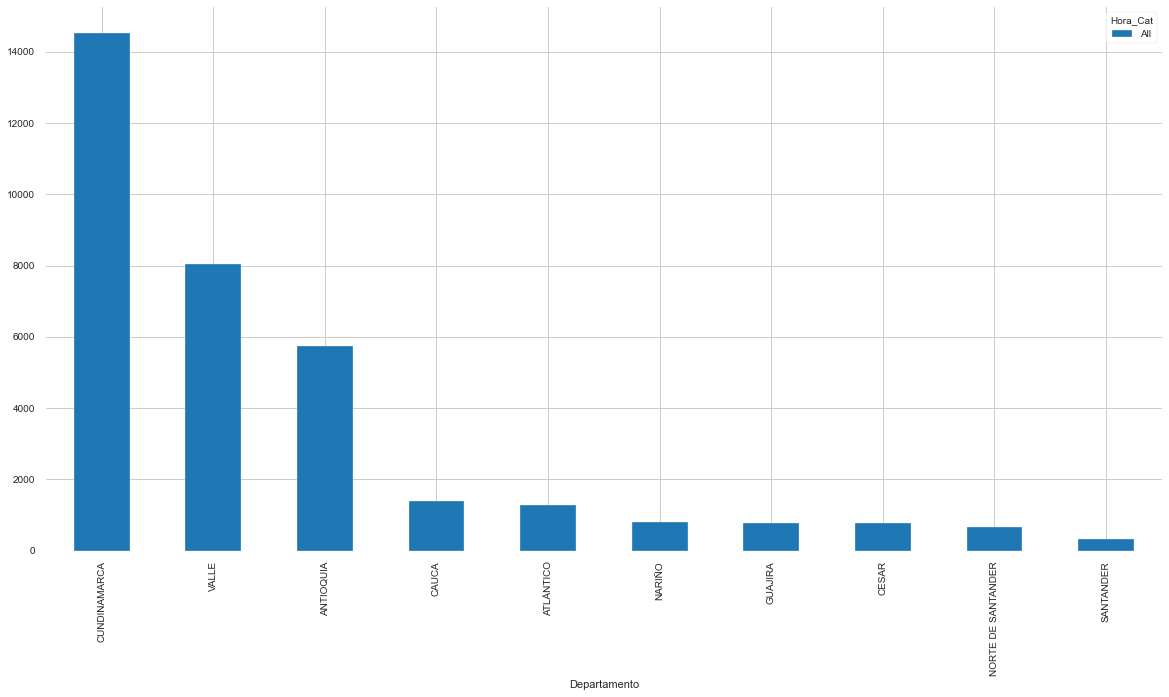

In [13]:
df_hurtos_top[["All"]].drop('All', axis=0).plot(kind='bar',figsize=(20,10),legend=True)

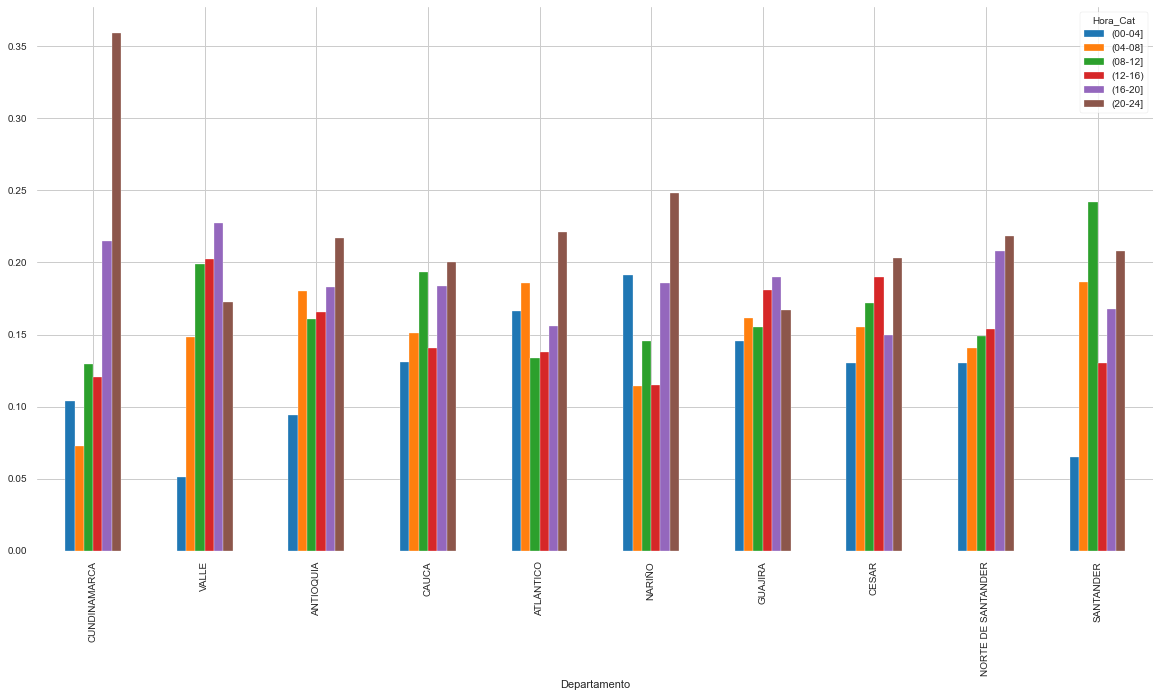

In [14]:
df_hurtos_cross_div.plot(kind='bar',figsize=(20,10),legend=True)

In [15]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_detartamento_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito
0.0


In [16]:
# Hora VS Arma Empleada
df_hurtos_hora_arma_c = pd.crosstab(index=df_hurtos.Hora_Cat,columns=df_hurtos["Arma empleada"],margins=True)
df_hurtos_hora_arma_c

Arma empleada,-,ARMA BLANCA / CORTOPUNZANTE,ARMA DE FUEGO,CONTUNDENTES,ESCOPOLAMINA,JERINGA,LLAVE MAESTRA,NO REPORTADO,SIN EMPLEO DE ARMAS,All
Hora_Cat,,,,,,,,,,
(00-04],1,81,761,22,54,0,1811,163,796,3689
(04-08],1,44,768,24,33,0,2643,137,853,4503
(08-12],0,51,1094,21,79,0,3202,144,1162,5753
(12-16),2,69,1241,32,106,0,2994,134,945,5523
(16-20],2,83,1966,42,54,0,4255,169,877,7448
(20-24],5,200,3434,46,45,1,3636,516,1748,9631
All,11,528,9264,187,371,1,18541,1263,6381,36547


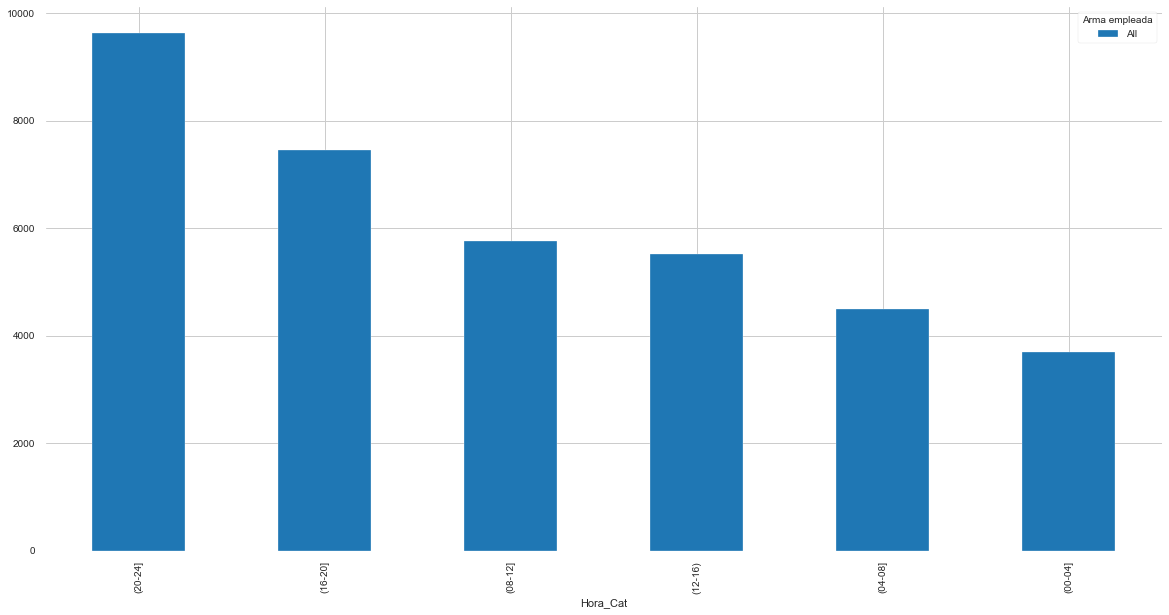

In [17]:
df_hurtos_hora_arma = df_hurtos_hora_arma_c.sort_values("All", ascending=False)
df_hurtos_hora_arma[["All"]].drop('All', axis=0).plot(kind='bar',figsize=(20,10))

In [18]:
df_hurtos_hora_arma = df_hurtos_hora_arma.div(df_hurtos_hora_arma.All, axis=0)
df_hurtos_hora_arma = df_hurtos_hora_arma.drop(['All'], axis=1).drop('All', axis=0)

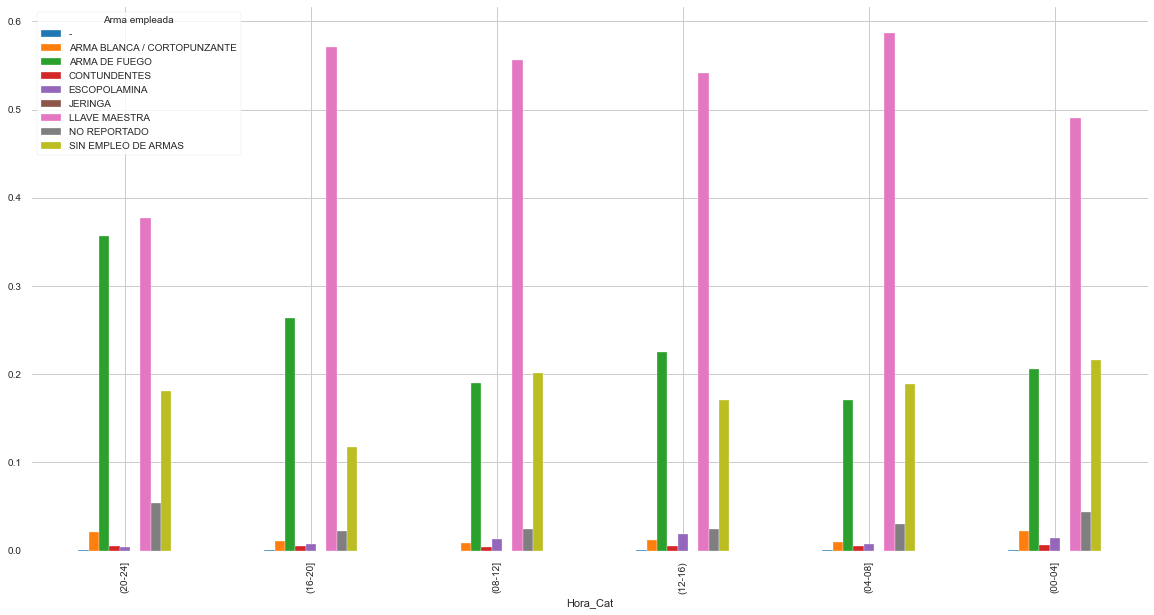

In [19]:
df_hurtos_hora_arma.plot(kind='bar',figsize=(20,10),legend=True)

In [20]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_arma_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el arma utilizada')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el arma utilizada
0.0


In [290]:
# Hora, Sitio
df_hurtos_hora_sitio_c = pd.crosstab(index=df_hurtos["Hora_Cat"],columns=df_hurtos["Clase de sitio"],margins=True)
#df_hurtos_hora_sitio_top = df_hurtos_hora_sitio_c.sort_values("All", ascending=False).head(15)
df_hurtos_hora_sitio_top = df_hurtos_hora_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_hora_sitio_top = df_hurtos_hora_sitio_top.div(df_hurtos_hora_sitio_top["All"],axis=0).drop("All",axis=1).drop("All",axis=0)

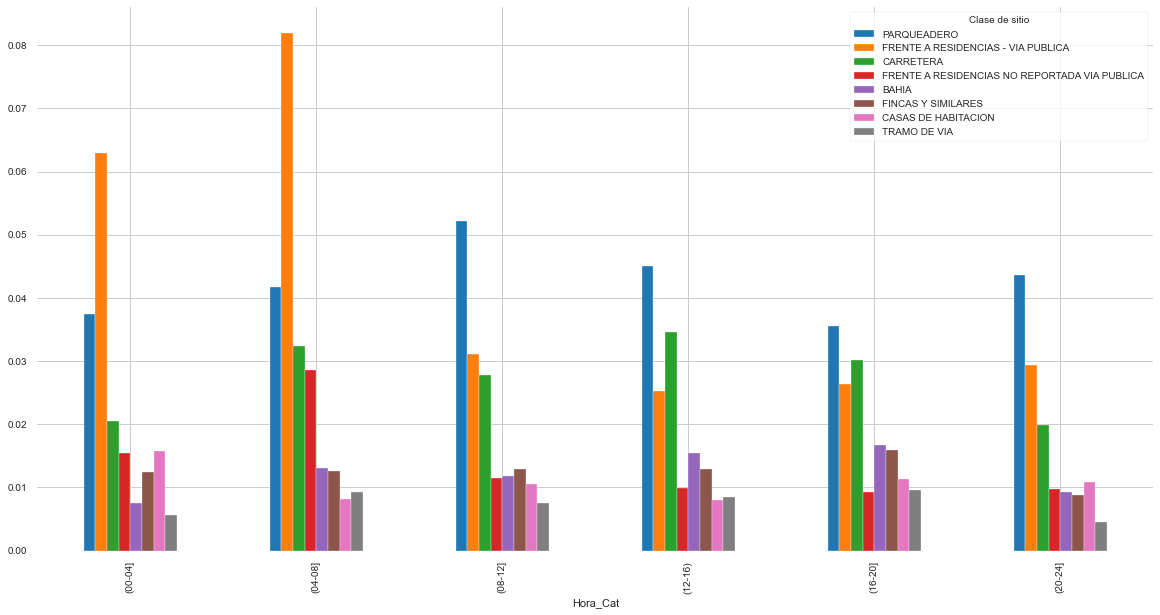

In [294]:
df_hurtos_hora_sitio_top.iloc[:,1:].plot(kind='bar',figsize=(20,10),legend=True)

In [22]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_sitio_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el sitio')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el sitio
6.595576950789246e-129


In [23]:
# Arma, Sitio
df_hurtos_arma_sitio_c = pd.crosstab(index=df_hurtos["Arma empleada"],columns=df_hurtos["Clase de sitio"],margins=True)
df_hurtos_arma_sitio_top = df_hurtos_arma_sitio_c.sort_values("All", ascending=False).head(15)
df_hurtos_arma_sitio_top

Clase de sitio,-,AEROPUERTO,ALIMENTADOR BUS M.I.O.,ALIMENTADOR BUS TRANSMILENIO,ALMACENES,ALOJAMIENTO,APARTAMENTO,APARTAMENTO EN CONJUNTO CERRADO,BAHIA,BANCOS,...,VEHICULO,VEHICULO BEAT,VEHICULO TAXI,VEHICULO UBER,VIAS PUBLICAS,ZONA DE PARQUEO,ZONA SELVÁTICA,ZONAS AZULES - VIA PUBLICA,ZONAS AZULES NO REPORTADA VIA PUBLICA,All
Arma empleada,,,,,,,,,,,,,,,,,,,,,
All,13,3,1,1,17,2,20,29,453,1,...,38,2,10,3,27866,84,6,4,1,36547
LLAVE MAESTRA,2,0,0,1,5,1,7,8,393,0,...,7,0,2,0,15056,48,0,2,0,18541
ARMA DE FUEGO,3,2,0,0,2,0,2,4,7,0,...,19,1,2,1,6754,2,3,1,1,9264
SIN EMPLEO DE ARMAS,7,0,1,0,10,1,11,15,41,1,...,9,0,1,0,4274,18,2,1,0,6381
NO REPORTADO,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,938,16,1,0,0,1263
ARMA BLANCA / CORTOPUNZANTE,1,0,0,0,0,0,0,0,2,0,...,3,1,3,2,404,0,0,0,0,528
ESCOPOLAMINA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,311,0,0,0,0,371
CONTUNDENTES,0,1,0,0,0,0,0,0,5,0,...,0,0,1,0,121,0,0,0,0,187
-,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,7,0,0,0,0,11


In [24]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_arma_sitio_c)

if (p < 0.05):
    print('El arma utilizada para el robo de un vehiculo puede tener relacion con el sitio')
    print(p)

El arma utilizada para el robo de un vehiculo puede tener relacion con el sitio
0.0


## Análisis Multivariado



In [262]:
df_multivariate = pd.concat([df_hurtos_hora_sitio_top,df_hurtos_hora_arma],axis=1)

In [263]:
df_multivariate

,VIAS PUBLICAS,PARQUEADERO,FRENTE A RESIDENCIAS - VIA PUBLICA,CARRETERA,FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,BAHIA,FINCAS Y SIMILARES,CASAS DE HABITACION,TRAMO DE VIA,-,ARMA BLANCA / CORTOPUNZANTE,ARMA DE FUEGO,CONTUNDENTES,ESCOPOLAMINA,JERINGA,LLAVE MAESTRA,NO REPORTADO,SIN EMPLEO DE ARMAS
(00-04],0.754947,0.037409,0.062890,0.020602,0.015451,0.007590,0.012470,0.015722,0.005693,0.000271,0.021957,0.206289,0.005964,0.014638,0.000000,0.490919,0.044185,0.215777
(04-08],0.703087,0.041750,0.081945,0.032423,0.028648,0.013102,0.012658,0.008217,0.009327,0.000222,0.009771,0.170553,0.005330,0.007328,0.000000,0.586942,0.030424,0.189429
(08-12],0.754563,0.052147,0.031114,0.027812,0.011472,0.011820,0.012863,0.010603,0.007474,0.000000,0.008865,0.190162,0.003650,0.013732,0.000000,0.556579,0.025030,0.201982
(12-16),0.761181,0.045084,0.025349,0.034583,0.009958,0.015390,0.012855,0.007967,0.008510,0.000362,0.012493,0.224697,0.005794,0.019192,0.000000,0.542097,0.024262,0.171103
(16-20],0.780612,0.035580,0.026316,0.030209,0.009264,0.016649,0.015977,0.011278,0.009533,0.000269,0.011144,0.263963,0.005639,0.007250,0.000000,0.571294,0.022691,0.117750
(20-24],0.784550,0.043609,0.029384,0.019936,0.009760,0.009241,0.008826,0.010798,0.004569,0.000519,0.020766,0.356557,0.004776,0.004672,0.000104,0.377531,0.053577,0.181497


In [281]:
df_multivariate.T

,(00-04],(04-08],(08-12],(12-16),(16-20],(20-24]
VIAS PUBLICAS,0.754947,0.703087,0.754563,0.761181,0.780612,0.784550
PARQUEADERO,0.037409,0.041750,0.052147,0.045084,0.035580,0.043609
FRENTE A RESIDENCIAS - VIA PUBLICA,0.062890,0.081945,0.031114,0.025349,0.026316,0.029384
CARRETERA,0.020602,0.032423,0.027812,0.034583,0.030209,0.019936
FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,0.015451,0.028648,0.011472,0.009958,0.009264,0.009760
BAHIA,0.007590,0.013102,0.011820,0.015390,0.016649,0.009241
FINCAS Y SIMILARES,0.012470,0.012658,0.012863,0.012855,0.015977,0.008826
CASAS DE HABITACION,0.015722,0.008217,0.010603,0.007967,0.011278,0.010798
TRAMO DE VIA,0.005693,0.009327,0.007474,0.008510,0.009533,0.004569
-,0.000271,0.000222,0.000000,0.000362,0.000269,0.000519


In [284]:
pca = PCA(n_components=2)
pca.fit(df_multivariate.T)
list_pca = pca.transform(df_multivariate.T)
print(pca.explained_variance_ratio_)
df_PCA = pd.DataFrame(list_pca, columns=["PCA_1","PCA_2"])


[0.98571821 0.01143038]


In [286]:
dict_ = dict()
for column_pca in df_PCA.columns:
    corr_list = []
    for column_transformed in df_multivariate.T.columns:
        corr_list.append(stats.spearmanr(df_multivariate.T[column_transformed].tolist(),df_PCA[column_pca].tolist())[0])
    dict_[f"corr_{column_pca}"] = corr_list

In [288]:
pd.DataFrame(dict_,index=df_multivariate.T.columns)

,corr_PCA_1,corr_PCA_2
(00-04],0.960784,-0.083591
(04-08],0.971104,0.093911
(08-12],0.945793,0.094992
(12-16),0.952528,0.058824
(16-20],0.940144,-0.031992
(20-24],0.960784,-0.172343
